# A/B Testing with Amazon SageMaker

- 원본소스(영문) : https://github.com/aws/amazon-sagemaker-examples/blob/master/sagemaker_endpoints/a_b_testing/a_b_testing.ipynb
- 블로그참조 : https://aws.amazon.com/ko/blogs/machine-learning/a-b-testing-ml-models-in-production-using-amazon-sagemaker/


운영 환경의 ML workflow에서 데이터 과학자와 데이터 엔지니어는 [자동 모델 튜닝] (https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning.html)을 수행하거나, 추가데이터 또는 보다 최신의 데이터를 이용하여 모델을 다시 학습하고, 특성(Feature)의 선택을 개선하는 등 머신러닝 모델을 개선하기 위해 다양한 시도를 진행합니다. 실제 운영환경에서 발생하는 데이터로 실행하는 A/B 테스트는 새롭게 만들어진 모델과 기존 모델들 사이에서 성능을 비교하는 효과적인 최종 절차입니다. A/B 테스트를 통해 여러분의 모델에 다양한 변형을 실험하고 이들이 어떻게 서로 영향을 미치는 지 비교해 볼 수 있고, 그 후 최고의 성능을 보이는 모델을 선택하여 기존모델을 대체하고 보다 나은 서비스를 제공할 수 있습니다.

아마존 SageMaker를 이용하면, 운영환경에서 하나의 동일한 엔드포인트를 위해 실제 추론은 다양한 버전의 머신러닝 모델을 실행하고 테스트할 수 있습니다. 모델의 실행시 운영 변형(production variant)을 이용하여 머신러닝 모델과 모델이 호스팅되는 리소스를 정의합니다. 또는 추론 호출시 해당 변형을 직접 지정할 수도 있습니다.

본 노트북에서 다음을 경험하게 됩니다:
- 특정 변형(variant)로 추론을 실행하고 모델을 평가하기
- 트래픽을 조정하여 점진적으로 새로운 모델로 라우팅하기 


---
### 사전준비

먼저 최신 SageMaker 기능이 포함 된 boto3의 업데이트 된 버전이 있는지 확인합니다.

In [1]:
!pip install -U awscli

     |████████████████████████████████| 3.6 MB 16.3 MB/s eta 0:00:01
     |████████████████████████████████| 7.7 MB 73.9 MB/s eta 0:00:01
  Attempting uninstall: botocore
    Found existing installation: botocore 1.20.99
    Uninstalling botocore-1.20.99:
      Successfully uninstalled botocore-1.20.99
  Attempting uninstall: awscli
    Found existing installation: awscli 1.19.99
    Uninstalling awscli-1.19.99:
      Successfully uninstalled awscli-1.19.99
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 1.3.0 requires botocore<1.20.50,>=1.20.49, but you have botocore 1.20.105 which is incompatible.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


## Configuration

필요한 라이브러리들을 import하고 기본 변수들을 초기화합니다.

In [2]:
%%time
%matplotlib inline
from datetime import datetime, timedelta
import time
import os
import boto3
import re
import json
from sagemaker import get_execution_role, session
from sagemaker.s3 import S3Downloader, S3Uploader

region = boto3.Session().region_name
role = get_execution_role()
sm_session = session.Session(boto3.Session())
sm = boto3.Session().client("sagemaker")
sm_runtime = boto3.Session().client("sagemaker-runtime")

# You can use a different bucket, but make sure the role you chose for this notebook
# has the s3:PutObject permissions. This is the bucket into which the model artifacts will be uploaded
bucket = sm_session.default_bucket()
prefix = "sagemaker/DEMO-VariantTargeting"

CPU times: user 1.2 s, sys: 249 ms, total: 1.45 s
Wall time: 1.38 s


## Step 1: 모델의 생성과 배포

### 사전학습(pre-trained) 모델을 S3로 업로드하기 

본 노트북은 사전학습이 완료되어 배포 가능한 두 개의 XGBoost 모델을 사용합니다. 모델은 SageMaker 예제 중 이탈방지(Churn Prediction)를 이용하여 학습되었습니다. 또는 여러분이 학습시킨 모델을 사용할 수도 있습니다. 만약 이미 학습된 모델이 S3에 있다면 제공되는 파일 대신 해당 s3 key를 이용할 수 있습니다.

본 예제에서 사용되는 모델은 모바일 고객이 현재의 이동통신사를 이탈할 가능성을 예측합니다. 예제에서 사용할 데이터셋은 University of California Irvine Repository Machine Learning Datasets과 Daniel T. Larose의 책 [Discovering Knowledge in Data](https://www.amazon.com/dp/0470908742/)을 통해 공개되었습니다.


In [3]:
model_url = S3Uploader.upload(
    local_path="model/xgb-churn-prediction-model.tar.gz", desired_s3_uri=f"s3://{bucket}/{prefix}"
)
model_url2 = S3Uploader.upload(
    local_path="model/xgb-churn-prediction-model2.tar.gz", desired_s3_uri=f"s3://{bucket}/{prefix}"
)
model_url, model_url2

('s3://sagemaker-us-east-1-307548999884/sagemaker/DEMO-VariantTargeting/xgb-churn-prediction-model.tar.gz',
 's3://sagemaker-us-east-1-307548999884/sagemaker/DEMO-VariantTargeting/xgb-churn-prediction-model2.tar.gz')

### 모델을 정의합니다.

사전 학습된 이탈방지 모델의 배포를 시작하겠습니다. 먼저 XGBoost 알고리즘이 있는 컨테이너 이미지와 모델 데이터로부터 모델 객체를 생성합니다.


In [4]:
from sagemaker.image_uris import retrieve


model_name = f"DEMO-xgb-churn-pred-{datetime.now():%Y-%m-%d-%H-%M-%S}"
model_name2 = f"DEMO-xgb-churn-pred2-{datetime.now():%Y-%m-%d-%H-%M-%S}"
image_uri = retrieve("xgboost", boto3.Session().region_name, "0.90-1")
image_uri2 = retrieve("xgboost", boto3.Session().region_name, "0.90-2")

sm_session.create_model(
    name=model_name, role=role, container_defs={"Image": image_uri, "ModelDataUrl": model_url}
)

sm_session.create_model(
    name=model_name2, role=role, container_defs={"Image": image_uri2, "ModelDataUrl": model_url2}
)

'DEMO-xgb-churn-pred2-2021-07-05-02-41-41'

### 변형(variants) 생성

이제 우리가 가진 두개의 모델을 위해서 각각 두 개의 변형(variant)를 생성합니다. (이들은 서로 다른 인스턴스 타입과 갯수를 가질 것입니다.)

두 변형(variant)모두 초기 가중치를 "1"로 세팅합니다. 이것은 50%의 요청은 Variant1으로, 그리고 나머지 50%의 요청은 Variant2로 라우팅되도록 합니다. (두 가중치의 합이 2이고 각 변형이 가중치 1을 가지므로, 각 변형은 1/2를 할당받고 전체 트래픽 50%를 각각 처리하게 됩니다.)


In [5]:
from sagemaker.session import production_variant

variant1 = production_variant(
    model_name=model_name,
    instance_type="ml.c5.4xlarge",
    initial_instance_count=1,
    variant_name="Variant1",
    initial_weight=1,
)
variant2 = production_variant(
    model_name=model_name2,
    instance_type="ml.c5.4xlarge",
    initial_instance_count=1,
    variant_name="Variant2",
    initial_weight=1,
)

(variant1, variant2)

({'ModelName': 'DEMO-xgb-churn-pred-2021-07-05-02-41-41',
  'InstanceType': 'ml.c5.4xlarge',
  'InitialInstanceCount': 1,
  'VariantName': 'Variant1',
  'InitialVariantWeight': 1},
 {'ModelName': 'DEMO-xgb-churn-pred2-2021-07-05-02-41-41',
  'InstanceType': 'ml.c5.4xlarge',
  'InitialInstanceCount': 1,
  'VariantName': 'Variant2',
  'InitialVariantWeight': 1})

### Deploy

이 두 변형을 이용하여 SageMaker 엔드포인트를 생성합니다.

In [6]:
endpoint_name = f"DEMO-xgb-churn-pred-{datetime.now():%Y-%m-%d-%H-%M-%S}"
print(f"EndpointName={endpoint_name}")

sm_session.endpoint_from_production_variants(
    name=endpoint_name, production_variants=[variant1, variant2]
)

EndpointName=DEMO-xgb-churn-pred-2021-07-05-02-41-45
-------------!

'DEMO-xgb-churn-pred-2021-07-05-02-41-45'

## Step 2: 배포된 모델 호출(invoke)하기

배포가 완료되면 이제 이 엔드포인트로 데이터를 보내고 실시간 추론을 할 수 있습니다.

다음 셀은 샘플데이터를 이용하여 우리가 만든 SageMaker 엔드포인트에 추론 요청을 보내는 코드입니다. (테스트 레코드를 이용하여 0.5초마다 엔드포인트를 호출하며 총 2분 정도 소요됩니다.)


In [7]:
# get a subset of test data for a quick test
!tail -120 test_data/test-dataset-input-cols.csv > test_data/test_sample_tail_input_cols.csv
print(f"Sending test traffic to the endpoint {endpoint_name}. \nPlease wait...")

with open("test_data/test_sample_tail_input_cols.csv", "r") as f:
    for row in f:
        print(".", end="", flush=True)
        payload = row.rstrip("\n")
        sm_runtime.invoke_endpoint(EndpointName=endpoint_name, ContentType="text/csv", Body=payload)
        time.sleep(0.5)

print("Done!")

Sending test traffic to the endpoint DEMO-xgb-churn-pred-2021-07-05-02-41-45. 
Please wait...
........................................................................................................................Done!


### 변형(variant)별 추론 실행

Amazon SageMaker는 각 변형에 대해 지연 시간 및 호출회수와 같은 지표를 Amazon CloudWatch에 남깁니다. (전체 지표 목록은 [여기] (https://alpha-docs-aws.amazon.com/sagemaker/latest/dg/monitoring-cloudwatch.html)를 참조합니다.) CloudWatch를 쿼리하여 변형당 호출수를 가져오고 호출이 분할되는 방식을 살펴보겠습니다.


In [8]:
import pandas as pd

cw = boto3.Session().client("cloudwatch")


def get_invocation_metrics_for_endpoint_variant(endpoint_name, variant_name, start_time, end_time):
    metrics = cw.get_metric_statistics(
        Namespace="AWS/SageMaker",
        MetricName="Invocations",
        StartTime=start_time,
        EndTime=end_time,
        Period=60,
        Statistics=["Sum"],
        Dimensions=[
            {"Name": "EndpointName", "Value": endpoint_name},
            {"Name": "VariantName", "Value": variant_name},
        ],
    )
    return (
        pd.DataFrame(metrics["Datapoints"])
        .sort_values("Timestamp")
        .set_index("Timestamp")
        .drop("Unit", axis=1)
        .rename(columns={"Sum": variant_name})
    )


def plot_endpoint_metrics(start_time=None):
    start_time = start_time or datetime.now() - timedelta(minutes=5)
    end_time = datetime.now()
    metrics_variant1 = get_invocation_metrics_for_endpoint_variant(
        endpoint_name, variant1["VariantName"], start_time, end_time
    )
    metrics_variant2 = get_invocation_metrics_for_endpoint_variant(
        endpoint_name, variant2["VariantName"], start_time, end_time
    )
    metrics_variants = metrics_variant1.join(metrics_variant2, how="outer")
    metrics_variants.plot()
    return metrics_variants

Waiting a minute for initial metric creation...


,Variant1,Variant2
Timestamp,,
2021-07-05 02:47:00+00:00,0.0,0.0
2021-07-05 02:48:00+00:00,42.0,33.0
2021-07-05 02:49:00+00:00,16.0,29.0


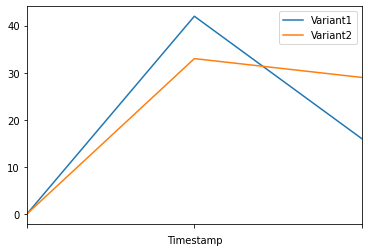

In [9]:
print("Waiting a minute for initial metric creation...")
time.sleep(60)
plot_endpoint_metrics()

### 특정 변형 호출하기 

이제 특정 변형을 호출 해 보겠습니다. 이를 위해 단순히 새 매개 변수를 사용하여 호출하려는 특정 ProductionVariant를 정의합니다. 이것을 사용하여 모든 요청에 대해 Variant1을 호출하겠습니다.


In [10]:
import numpy as np

predictions = ""

print(f"Sending test traffic to the endpoint {endpoint_name}. \nPlease wait...")
with open("test_data/test_sample_tail_input_cols.csv", "r") as f:
    for row in f:
        print(".", end="", flush=True)
        payload = row.rstrip("\n")
        response = sm_runtime.invoke_endpoint(
            EndpointName=endpoint_name,
            ContentType="text/csv",
            Body=payload,
            TargetVariant=variant1["VariantName"],
        )
        predictions = ",".join([predictions, response["Body"].read().decode("utf-8")])
        time.sleep(0.5)

# Convert our predictions to a numpy array
pred_np = np.fromstring(predictions[1:], sep=",")

# Convert the prediction probabilities to binary predictions of either 1 or 0
threshold = 0.5
preds = np.where(pred_np > threshold, 1, 0)
print("Done!")

Sending test traffic to the endpoint DEMO-xgb-churn-pred-2021-07-05-02-41-45. 
Please wait...
........................................................................................................................Done!



변형 별 트래픽을 다시 확인하면 이번에는 모든 호출이 해당 변형을 대상으로했기 때문에 호출 수가 Variant1에 대해서만 증가했음을 알 수 있습니다.

,Variant1,Variant2
Timestamp,,
2021-07-05 02:47:00+00:00,0.0,0.0
2021-07-05 02:48:00+00:00,42.0,33.0
2021-07-05 02:49:00+00:00,16.0,29.0
2021-07-05 02:50:00+00:00,67.0,0.0


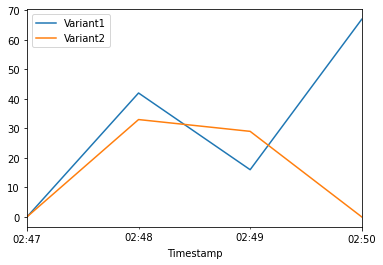

In [11]:
time.sleep(20)  # let metrics catch up
plot_endpoint_metrics()

## Step 3: 변형에 대한 성능 평가 

### Variant 1 성능 평가

타겟팅 기능을 사용하여 Variant1에 대한 정확성, 정밀도, 재현율, F1 점수 및 ROC / AUC를 평가 해 보겠습니다.



Accuracy: 0.9583333333333334
Precision: 0.9411764705882353
Recall: 0.8
F1 Score: 0.8648648648648648
AUC is 0.895


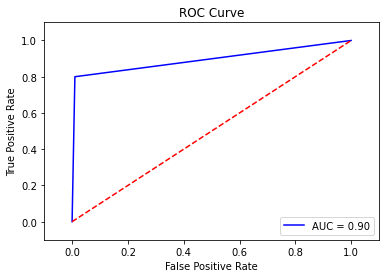

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
from sklearn.metrics import roc_auc_score

# Let's get the labels of our test set; we will use these to evaluate our predictions
!tail -121 test_data/test-dataset.csv > test_data/test_dataset_sample_tail.csv
df_with_labels = pd.read_csv("test_data/test_dataset_sample_tail.csv")
test_labels = df_with_labels.iloc[:, 0]
labels = test_labels.to_numpy()

# Calculate accuracy
accuracy = sum(preds == labels) / len(labels)
print(f"Accuracy: {accuracy}")

# Calculate precision
precision = sum(preds[preds == 1] == labels[preds == 1]) / len(preds[preds == 1])
print(f"Precision: {precision}")

# Calculate recall
recall = sum(preds[preds == 1] == labels[preds == 1]) / len(labels[labels == 1])
print(f"Recall: {recall}")

# Calculate F1 score
f1_score = 2 * (precision * recall) / (precision + recall)
print(f"F1 Score: {f1_score}")

# Calculate AUC
auc = round(roc_auc_score(labels, preds), 4)
print("AUC is " + repr(auc))

fpr, tpr, _ = metrics.roc_curve(labels, preds)

plt.title("ROC Curve")
plt.plot(fpr, tpr, "b", label="AUC = %0.2f" % auc)
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

### Variant2 성능 평가
Variant2에 대한 매트릭도 수집해 봅니다.

In [13]:
predictions2 = ""
print(f"Sending test traffic to the endpoint {endpoint_name}. \nPlease wait...")
with open("test_data/test_sample_tail_input_cols.csv", "r") as f:
    for row in f:
        print(".", end="", flush=True)
        payload = row.rstrip("\n")
        response = sm_runtime.invoke_endpoint(
            EndpointName=endpoint_name,
            ContentType="text/csv",
            Body=payload,
            TargetVariant=variant2["VariantName"],
        )
        predictions2 = ",".join([predictions2, response["Body"].read().decode("utf-8")])
        time.sleep(0.5)

# Convert to numpy array
pred_np2 = np.fromstring(predictions2[1:], sep=",")

# Convert to binary predictions
thresh = 0.5
preds2 = np.where(pred_np2 > threshold, 1, 0)

print("Done!")

Sending test traffic to the endpoint DEMO-xgb-churn-pred-2021-07-05-02-41-45. 
Please wait...
........................................................................................................................Done!


When we again check the traffic per variant, this time we see that the number of invocations only incremented for Variant2, because all invocations were targeted at that variant:

,Variant1,Variant2
Timestamp,,
2021-07-05 02:48:00+00:00,42.0,33.0
2021-07-05 02:49:00+00:00,16.0,29.0
2021-07-05 02:50:00+00:00,67.0,0.0
2021-07-05 02:51:00+00:00,53.0,15.0
2021-07-05 02:52:00+00:00,0.0,105.0


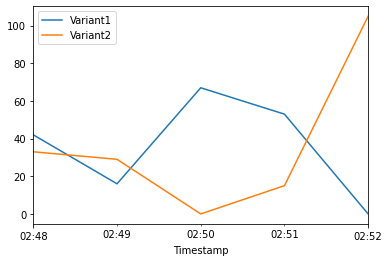

In [14]:
time.sleep(60)  # give metrics time to catch up
plot_endpoint_metrics()

마찬가지 방식으로 정확성, 정밀도, 재현율, F1 점수 및 ROC / AUC를 평가합니다.

Accuracy: 0.9583333333333334
Precision: 0.8947368421052632
Recall: 0.85
F1 Score: 0.8717948717948718
AUC is 0.915


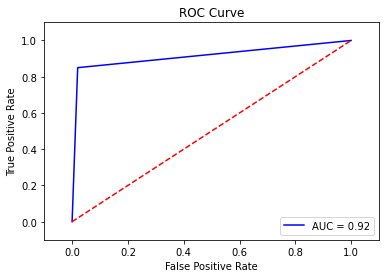

In [15]:
# Calculate accuracy
accuracy2 = sum(preds2 == labels) / len(labels)
print(f"Accuracy: {accuracy2}")

# Calculate precision
precision2 = sum(preds2[preds2 == 1] == labels[preds2 == 1]) / len(preds2[preds2 == 1])
print(f"Precision: {precision2}")

# Calculate recall
recall2 = sum(preds2[preds2 == 1] == labels[preds2 == 1]) / len(labels[labels == 1])
print(f"Recall: {recall2}")

# Calculate F1 score
f1_score2 = 2 * (precision2 * recall2) / (precision2 + recall2)
print(f"F1 Score: {f1_score2}")

auc2 = round(roc_auc_score(labels, preds2), 4)
print("AUC is " + repr(auc2))

fpr2, tpr2, _ = metrics.roc_curve(labels, preds2)

plt.title("ROC Curve")
plt.plot(fpr2, tpr2, "b", label="AUC = %0.2f" % auc2)
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

정의 된 대부분의 측정 항목에 대해 Variant2가 더 나은 성능을 발휘하는 것으로 확인되었으며, 최종 배포 모델로 선택될 가능성이 높습니다.


## Step 4: 선정된 변형을 최종 운영환경으로 승격

이제 Variant2가 Variant1에 비해 더 나은 것으로 결정 했으므로 더 많은 트래픽을 여기로 이동하기로 결정하였습니다.

TargetVariant를 사용하여 선택한 변형을 계속 호출 할 수 있습니다. 더 간단한 방법은 UpdateEndpointWeightsAndCapacities를 사용하여 각 변형에 할당 된 가중치를 업데이트하는 것입니다. 이렇게하면 엔드 포인트를 업데이트하지 않고도 프로덕션 변형에 대한 트래픽 배포가 변경됩니다.

변형 가중치는 다음과 같습니다.


In [16]:
{
    variant["VariantName"]: variant["CurrentWeight"]
    for variant in sm.describe_endpoint(EndpointName=endpoint_name)["ProductionVariants"]
}

{'Variant1': 1.0, 'Variant2': 1.0}

먼저 엔드 포인트를 쉽게 호출하는 메서드를 작성합니다.(앞 단계에서 수행한 작업의 복사본입니다.)

In [17]:
def invoke_endpoint_for_two_minutes():
    with open("test_data/test-dataset-input-cols.csv", "r") as f:
        for row in f:
            print(".", end="", flush=True)
            payload = row.rstrip("\n")
            response = sm_runtime.invoke_endpoint(
                EndpointName=endpoint_name, ContentType="text/csv", Body=payload
            )
            response["Body"].read()
            time.sleep(1)

공평하게 분할되는지 확인하기 위해 약간의 추론 호출을 실행해 봅니다. 

..............................................................................................................................................................................................................................................................................................................................................

,Variant1,Variant2
Timestamp,,
2021-07-05 02:53:00+00:00,2.0,4.0
2021-07-05 02:54:00+00:00,32.0,27.0
2021-07-05 02:55:00+00:00,28.0,31.0
2021-07-05 02:56:00+00:00,34.0,25.0
2021-07-05 02:57:00+00:00,28.0,31.0
2021-07-05 02:58:00+00:00,31.0,28.0


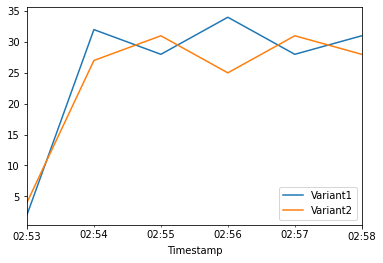

In [18]:
invocation_start_time = datetime.now()
invoke_endpoint_for_two_minutes()
time.sleep(20)  # give metrics time to catch up
plot_endpoint_metrics(invocation_start_time)

이제 UpdateEndpointWeightsAndCapacities를 사용하여 각 변형에 새 가중치를 할당하여 트래픽의 75 %를 Variant2로 이동시키겠습니다. Amazon SageMaker는 이제 추론 요청의 75 %를 Variant2로 보내고 나머지 25 %는 Variant1로 보냅니다.


In [19]:
sm.update_endpoint_weights_and_capacities(
    EndpointName=endpoint_name,
    DesiredWeightsAndCapacities=[
        {"DesiredWeight": 25, "VariantName": variant1["VariantName"]},
        {"DesiredWeight": 75, "VariantName": variant2["VariantName"]},
    ],
)

{'EndpointArn': 'arn:aws:sagemaker:us-east-1:307548999884:endpoint/demo-xgb-churn-pred-2021-07-05-02-41-45',
 'ResponseMetadata': {'RequestId': 'd6cfed41-148c-4a27-b080-9fb7feeb7f58',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'd6cfed41-148c-4a27-b080-9fb7feeb7f58',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '107',
   'date': 'Mon, 05 Jul 2021 02:59:54 GMT'},
  'RetryAttempts': 0}}

In [20]:
print("Waiting for update to complete")
while True:
    status = sm.describe_endpoint(EndpointName=endpoint_name)["EndpointStatus"]
    if status in ["InService", "Failed"]:
        print("Done")
        break
    print(".", end="", flush=True)
    time.sleep(1)

{
    variant["VariantName"]: variant["CurrentWeight"]
    for variant in sm.describe_endpoint(EndpointName=endpoint_name)["ProductionVariants"]
}

Waiting for update to complete
.........................................................................................Done


{'Variant1': 25.0, 'Variant2': 75.0}

이제 이것이 호출 메트릭에 어떤 영향을 미쳤는지 확인해 보겠습니다.

..............................................................................................................................................................................................................................................................................................................................................

,Variant1,Variant2
Timestamp,,
2021-07-05 02:53:00+00:00,2.0,4.0
2021-07-05 02:54:00+00:00,32.0,27.0
2021-07-05 02:55:00+00:00,28.0,31.0
2021-07-05 02:56:00+00:00,34.0,25.0
2021-07-05 02:57:00+00:00,28.0,31.0
2021-07-05 02:58:00+00:00,31.0,28.0
2021-07-05 02:59:00+00:00,19.0,14.0
2021-07-05 03:00:00+00:00,0.0,0.0
2021-07-05 03:01:00+00:00,9.0,20.0


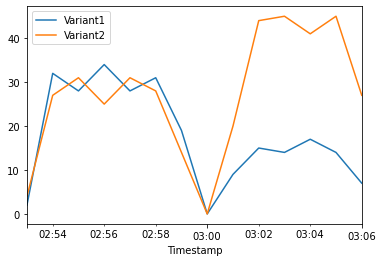

In [21]:
invoke_endpoint_for_two_minutes()
time.sleep(20)  # give metrics time to catch up
plot_endpoint_metrics(invocation_start_time)

매트릭을 계속 모니터링하면서 변형의 성능에 만족하였다면 이제 트래픽의 100%를 해당 변형으로 라우팅할 수 있습니다. UpdateEndpointWeightsAndCapacities를 사용하여 변형에 대한 트래픽 할당을 업데이트합니다. Variant1의 가중치는 0으로, Variant2의 가중치는 1로 설정합니다. 이제 Amazon SageMaker는 모든 추론 요청의 100 %를 Variant2로 보냅니다.


In [22]:
sm.update_endpoint_weights_and_capacities(
    EndpointName=endpoint_name,
    DesiredWeightsAndCapacities=[
        {"DesiredWeight": 0, "VariantName": variant1["VariantName"]},
        {"DesiredWeight": 1, "VariantName": variant2["VariantName"]},
    ],
)
print("Waiting for update to complete")
while True:
    status = sm.describe_endpoint(EndpointName=endpoint_name)["EndpointStatus"]
    if status in ["InService", "Failed"]:
        print("Done")
        break
    print(".", end="", flush=True)
    time.sleep(1)

{
    variant["VariantName"]: variant["CurrentWeight"]
    for variant in sm.describe_endpoint(EndpointName=endpoint_name)["ProductionVariants"]
}

Waiting for update to complete
..........................................................Done


{'Variant1': 0.0, 'Variant2': 1.0}

..............................................................................................................................................................................................................................................................................................................................................

,Variant1,Variant2
Timestamp,,
2021-07-05 02:53:00+00:00,2.0,4.0
2021-07-05 02:54:00+00:00,32.0,27.0
2021-07-05 02:55:00+00:00,28.0,31.0
2021-07-05 02:56:00+00:00,34.0,25.0
2021-07-05 02:57:00+00:00,28.0,31.0
2021-07-05 02:58:00+00:00,31.0,28.0
2021-07-05 02:59:00+00:00,19.0,14.0
2021-07-05 03:00:00+00:00,0.0,0.0
2021-07-05 03:01:00+00:00,9.0,20.0


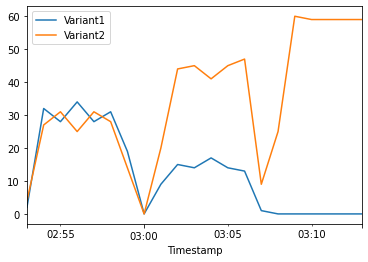

In [23]:
invoke_endpoint_for_two_minutes()
time.sleep(20)  # give metrics time to catch up
plot_endpoint_metrics(invocation_start_time)

아래쪽 그래프에 표현된 변형에 대한 총 호출 Amazon CloudWatch 지표는 모든 추론 요청이 Variant2에 의해 처리되고 있고 Variant1에 의해 처리되는 추론 요청이 없음을 보여줍니다.

이제 안전하게 엔드 포인트를 업데이트하고 엔드 포인트에서 Variant1을 삭제할 수 있습니다. 또한 엔드포인트에 새 변형을 추가하고 2-4 단계를 수행하여 프로덕션에서 새 모델을 계속 테스트 할 수도 있습니다.



## 엔드포인트 삭제

이 엔드 포인트를 더 이상 사용할 계획이없는 경우 추가 요금이 발생하지 않도록 엔드 포인트를 삭제합니다.

In [24]:
sm_session.delete_endpoint(endpoint_name)